In [1]:
# Fundamental environment setup
import matplotlib
import numpy as np
import psutil
import ray
import seaborn as sns
import copy
import urllib.request
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest
from optmethods.loss import LogisticRegression
from optmethods.utils import get_trace, relative_round

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [2]:
ray.shutdown()
num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)

RayContext(dashboard_url='', python_version='3.8.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '10.68.186.178', 'raylet_ip_address': '10.68.186.178', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-26_19-00-48_055372_20182/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-26_19-00-48_055372_20182/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-26_19-00-48_055372_20182', 'metrics_export_port': 49128, 'gcs_address': '10.68.186.178:63030', 'address': '10.68.186.178:63030', 'node_id': '07c42cb9d1d88c178b9df20683c3ca6f6e30205321eb8a3f8c008ad3'})

In [80]:
dataset = 'a9a' # Modify
n_workers = 10 # Modify
regul = 5e-4 # Modify
com_cost = 1
local_cost = 1e-2 
bs = 64 # Modify

In [81]:
data_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset}"
data_path = f"./{dataset}"
print(data_path)
# assert 0
f = urllib.request.urlretrieve(data_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

n, dim = A.shape  # \# of data and dimension for each data: 49749, 300
print(n, dim)
if n % num_cpus != 0:
    A = A[:n - (n % num_cpus)]
    b = b[:n - (n % num_cpus)]
b_unique = np.unique(b)
if (b_unique == [1, 2]).all():
    # Transform labels {1, 2} to {0, 1}
    b = b - 1
elif (b_unique == [-1, 1]).all():
    # Transform labels {-1, 1} to {0, 1}
    b = (b + 1) / 2
else:
    # replace class labels with 0's and 1's
    b = 1. * (b == b[0])
# A = A.toarray()
l1 = 0
loss = LogisticRegression(A, b, l1=l1, l2=0)
n, dim = A.shape
if n <= 20000 or dim <= 20000:
    print('Computing the smoothness constant via SVD, it may take a few minutes...')
# L = loss.smoothness
oL = loss.smoothness
m = int(n / n_workers)
L = loss.batch_smoothness(bs)
l2 = regul * L

kappa = L / l2
local_round = int(np.sqrt(kappa))

./a9a
32561 123
Computing the smoothness constant via SVD, it may take a few minutes...


In [82]:
# New results
k1 = 1
file_name = f'1000_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_lsteps20_kappa_2000_15001_{k1}_1.txt'
with open(f'./logs/{file_name}', 'r') as minput:
    total_its_str1 = minput.readline().split(',')
    total_its1 = [float(i) for i in total_its_str1]
    
    lsvrg_str1 = minput.readline().split(',')
    qlsvrg_str1 = minput.readline().split(',')
    lsvrg_res1 = [float(i) for i in lsvrg_str1]
    qlsvrg_res1 = [float(i) for i in qlsvrg_str1]
    
print(file_name, '\n', lsvrg_res1[:5], '\n', qlsvrg_res1[:5])

1000_a9a_n10_bs64_cosize10_lsteps20_kappa_2000_15001_1_1.txt 
 [0.36141578211842657, 0.2135089818188029, 0.14636375905516374, 0.08891105594562593, 0.06386089314246529] 
 [0.36141578211842657, 0.20969265151110977, 0.19119525812585098, 0.15280874558765611, 0.13658944392819383]


In [84]:
# New results
k3 = 4
file_name = f'1000_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_lsteps20_kappa_2000_15001_{k3}_1.txt'
with open(f'./logs/{file_name}', 'r') as minput:
    total_its_str3 = minput.readline().split(',')
    total_its3 = [float(i) for i in total_its_str3]
    
    lsvrg_str3 = minput.readline().split(',')
    qlsvrg_str3 = minput.readline().split(',')
    lsvrg_res3 = [float(i) for i in lsvrg_str3]
    qlsvrg_res3 = [float(i) for i in qlsvrg_str3]
    
print(file_name, '\n', lsvrg_res3[:5], '\n', qlsvrg_res3[:5])

1000_a9a_n10_bs64_cosize10_lsteps20_kappa_2000_15001_4_1.txt 
 [0.36141578211842657, 0.21551766236398978, 0.1473842928129065, 0.08769509980330747, 0.06275858797555073] 
 [0.36141578211842657, 0.1913221828144797, 0.16931964963855856, 0.12026051077851563, 0.09839295981304014]


In [87]:
# New results 
k4 = 11
file_name = f'1000_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_lsteps20_kappa_2000_15001_{k4}_1.txt'
with open(f'./logs/{file_name}', 'r') as minput:
    total_its_str4 = minput.readline().split(',')
    total_its4 = [float(i) for i in total_its_str4]
    
    lsvrg_str4 = minput.readline().split(',')
    qlsvrg_str4 = minput.readline().split(',')
    lsvrg_res4 = [float(i) for i in lsvrg_str4]
    qlsvrg_res4 = [float(i) for i in qlsvrg_str4]
    
print(file_name, '\n', lsvrg_res4[:5], '\n', qlsvrg_res4[:5])

1000_a9a_n10_bs64_cosize10_lsteps20_kappa_2000_15001_11_1.txt 
 [0.36141578211842657, 0.21295949619725668, 0.14561238488618683, 0.08586367165897046, 0.06371562919987261] 
 [0.36141578211842657, 0.18927567299269749, 0.15730583566219164, 0.10700365488037106, 0.08410614615451756]


In [88]:
# New results
k5 = 61
file_name = f'1000_{dataset}_n{n_workers}_bs{bs}_cosize{n_workers}_lsteps20_kappa_2000_15001_{k5}_1.txt'
with open(f'./logs/{file_name}', 'r') as minput:
    total_its_str5 = minput.readline().split(',')
    total_its5 = [float(i) for i in total_its_str5]
    
    lsvrg_str5 = minput.readline().split(',')
    qlsvrg_str5 = minput.readline().split(',')
    lsvrg_res5 = [float(i) for i in lsvrg_str5]
    qlsvrg_res5 = [float(i) for i in qlsvrg_str5]
    
print(file_name)

1000_a9a_n10_bs64_cosize10_lsteps20_kappa_2000_15001_61_1.txt


In [90]:
# Compute the cost of different methods
# sgd_cost = com_cost * sgd_it + np.sum(sgd[:sgd_it]) * local_cost * bs
# skip_cost = (com_cost + m * local_round) * total_its
total_its = total_its1
total_its = np.array(total_its)
kappa0 = oL / l2
kappa = L / l2
p0 = 1 / np.sqrt(kappa0)
p = 1 / np.sqrt(kappa)
local_round0 = int(1 / p0)
local_round = int(1 / p)
q0 = 4 / kappa0
q = 4 / kappa
# proxskip_cost = (com_cost + m * local_round * local_cost)  * total_its
sproxskip_cost = (com_cost + (m + local_round * bs) * local_cost) * total_its
vr_proxskip_cost = (com_cost + (q * m + local_round * bs) * local_cost) * total_its
epsilon = 1e-5
# print(com_cost, m, local_round, bs, k1, dim, total_its[:30])
# print(k1, k2, k3, k4, k5, dim)
qlsvrg_cost1 = (com_cost + (q * m + local_round * bs * k1 / dim) * local_cost) * total_its
# qlsvrg_cost2 = (com_cost + (q * m + local_round * bs * k2 / dim) * local_cost) * total_its
qlsvrg_cost3 = (com_cost + (q * m + local_round * bs * k3 / dim) * local_cost) * total_its
qlsvrg_cost4 = (com_cost + (q * m + local_round * bs * k4 / dim) * local_cost) * total_its
qlsvrg_cost5 = (com_cost + (q * m + local_round * bs * k5 / dim) * local_cost) * total_its
qlsvrg_cost1[0] += epsilon
# qlsvrg_cost2[0] += epsilon
qlsvrg_cost3[0] += epsilon
qlsvrg_cost4[0] += epsilon
# qlsvrg_cost5[0] += epsilon
# proxskip_cost[0] += epsilon

print(qlsvrg_cost1[:5], '\n', qlsvrg_cost3[:5], '\n', qlsvrg_cost4[:5], '\n')

[1.00000000e-05 1.29402309e+00 2.58804618e+00 3.88206927e+00
 5.17609236e+00] 
 [1.00000000e-05 1.98085236e+00 3.96170472e+00 5.94255707e+00
 7.92340943e+00] 
 [1.00000000e-05 3.58345398e+00 7.16690797e+00 1.07503620e+01
 1.43338159e+01] 



/tmp/ipykernel_20182/2941424971.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


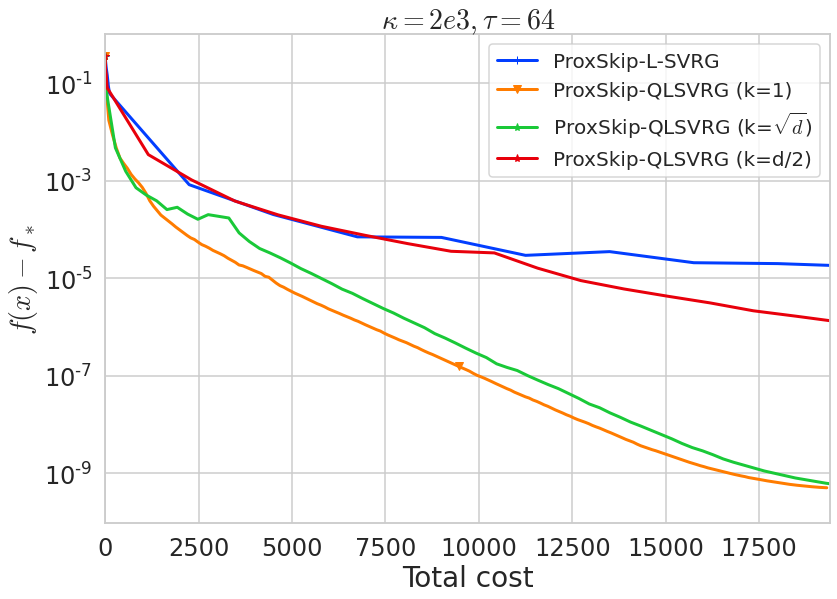

In [91]:
# !pip install brokenaxes
# from brokenaxes import brokenaxes

size = 30
markevery = 2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 24  # 40
plt.rcParams['ytick.labelsize'] = 24  # 40
plt.rcParams['legend.fontsize'] = 20  # 30
plt.rcParams['axes.titlesize'] = 28  # 40
plt.rcParams['axes.labelsize'] = 28  # 40
plt.rcParams["figure.figsize"] = [13, 9]
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel(r'Total cost')
plt.yscale('log')
# plt.xscale('log')
plt.title(fr"$\kappa = 2e3, \tau={bs}$")
# plt.legend()
plt.grid(b=True)
markevery = 100
# print(lsvrg_res)
 
start = 0
# end = 130
end = 200
mlen = len(vr_proxskip_cost)
x_start = min(vr_proxskip_cost[0], qlsvrg_cost1[0], qlsvrg_cost3[0], qlsvrg_cost4[0])
x_end = min(vr_proxskip_cost[end], qlsvrg_cost1[end], qlsvrg_cost3[end], qlsvrg_cost4[end])
plt.xlim(x_start, x_end)
# plt.plot(c1, mfunc1, marker='*', label=r"Theoretical", markersize=8)
# print(0.99*proxskip_cost[0], 1.001*proxskip_cost[0], proxskip_cost[2])
# bax = brokenaxes(xlims=((0, epsilon), (x_start, x_end)))
# plt.plot(sproxskip_cost[start:], sproxskip_vals[start:], marker='+', label=r'ProxSkip', markersize=8, markevery=markerevery)
plt.plot(vr_proxskip_cost[start:end], lsvrg_res1[start:end], marker='+', label=r'ProxSkip-L-SVRG', markersize=8, markevery=markevery)
plt.plot(qlsvrg_cost1[start:end], qlsvrg_res1[start:end], marker='v', label=r'ProxSkip-QLSVRG (k=1)', markersize=8, markevery=markevery)
# plt.plot(qlsvrg_cost2, qlsvrg_res2, marker='d', label=r'ProxSkip-QLSVRG (k=2)', markersize=8)
# plt.plot(costs_real, np.ones(len(costs_real)), linestyle='--', c='red', linewidth=1.5)
# plt.plot(qlsvrg_cost3[start:end], qlsvrg_res3[start:end], marker='8', label=r'ProxSkip-QLSVRG (k=4)', markersize=8, markevery=markevery)
plt.plot(qlsvrg_cost4[start:end], qlsvrg_res4[start:end], marker='*', label=r'ProxSkip-QLSVRG (k=$\sqrt{d}$)', markersize=8, markevery=markevery)
plt.plot(qlsvrg_cost5[start:], qlsvrg_res5[start:], marker='*', label=r'ProxSkip-QLSVRG (k=d/2)', markersize=8, markevery=markevery)
plt.legend()
plt.savefig(f'{file_name}.pdf')
plt.show()
plt.close()